In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

from utils.PINNnet import PINN
#from utils.plot_func import plot_field, model_pred, plot_error_field, plot_loss
from utils.plot_func import plot_field
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
## hyperparameter
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5

In [3]:
import joblib
state_dict = joblib.load('model_batches.joblib')
model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
model = model.to(device)

In [12]:
def model_pred(model, Lx, Ly, N=100):
    x, y = torch.linspace(-Lx, Lx, N), torch.linspace(-0.5, Ly, N)
    x, y = torch.meshgrid(x, y)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    model = model.to('cpu')
    inputs = torch.cat([x, y], dim=-1)
    p_real = model(inputs)[:, 0].detach().numpy()
    p_imag = model(inputs)[:, 1].detach().numpy()
    p_real, p_imag = p_real.reshape(N, N), p_imag.reshape(N, N)

    x, y = (x+1) * 100, -(y-1) * 100
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_real, levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('PINN (real)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.gca().invert_yaxis()

    plt.subplot(1, 2, 2)
    p_max = 0.2
    cmap = matplotlib.cm.seismic
    norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
    plt.contourf(x.reshape(N, N), y.reshape(N, N), p_imag, levels=400, cmap=cmap, origin='lower', norm=norm)
    plt.colorbar()
    plt.title('PINN (imag)')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('PINN.jpg')
    

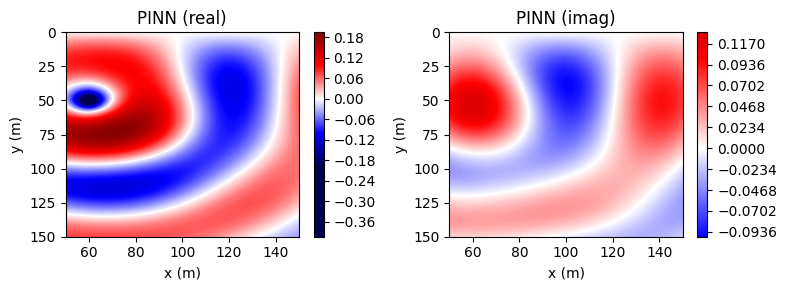

In [13]:
model_pred(model, 0.5, 1)

In [7]:
# fixed parameters
L = 1
Lx, Ly = L, L
src = [-0.4, 0.5]
k = 2 * np.pi * 20 / 1500 * 100

In [8]:
import scipy
x, y = np.linspace(-0.5, 0.5, 200), np.linspace(-0.5, 1, 200)
x, y = np.meshgrid(x, y)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)

hankel = scipy.special.hankel2(0, k * np.sqrt((x-src[0]) ** 2 + (y-src[1]) ** 2)) -\
    scipy.special.hankel2(0, k * np.sqrt((x-src[0]) ** 2 + (y-1.5) ** 2))
field = 0.25j * hankel
field = field.reshape(200, 200)
p_ref = field

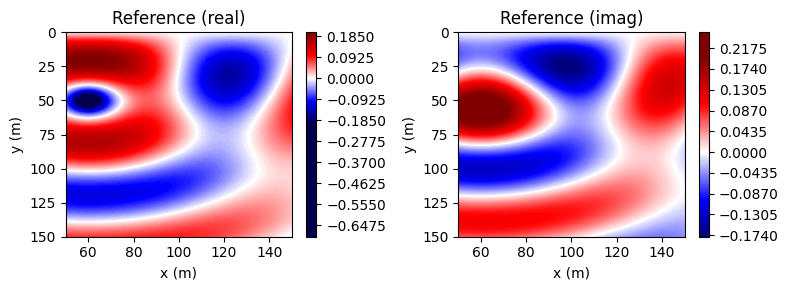

In [9]:
plot_field(field, [50, 150], [-150, 0], bar_max=0.2, title='Reference', filename='Reference')

Error(Real) 0.1318426877260208, Error(Imag) -0.024261923506855965


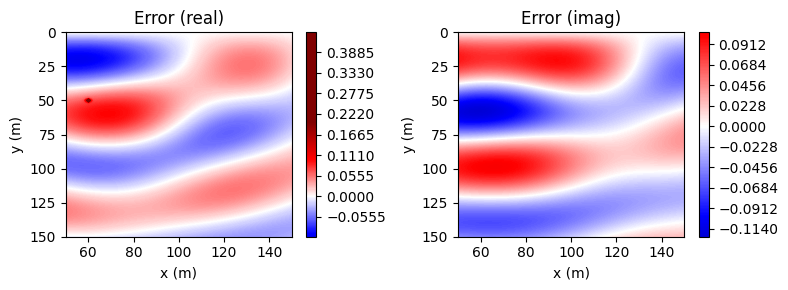

In [10]:
N = 100
k = 2 * np.pi * 20 / 1500 *100
x, y = torch.linspace(-0.5, 0.5, N), torch.linspace(-0.5, 1, N)
x, y = torch.meshgrid(x, y)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
model = model.to('cpu')
inputs = torch.cat([x, y], dim=-1)
p_real = model(inputs)[:, 0].detach().numpy()
p_imag = model(inputs)[:, 1].detach().numpy()
p_real, p_imag = p_real.reshape(N, N), p_imag.reshape(N, N)

x, y = x.numpy(), y.numpy()
hankel = scipy.special.hankel2(0, k * np.sqrt((x-src[0]) ** 2 + (y-src[1]) ** 2) + 1e-6) - scipy.special.hankel2(0, k * np.sqrt((x-src[0]) ** 2 + (y-1.5) ** 2) + 1e-6)
p_ref = 0.25j * hankel
p_ref_real, p_ref_imag = p_ref.real.reshape(N, N), p_ref.imag.reshape(N, N)

x, y = (x+1) * 100, -(y-1) * 100

error_real = p_real - p_ref_real
error_imag = p_imag - p_ref_imag

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
p_max = 0.2
cmap = matplotlib.cm.seismic
norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
plt.contourf(x.reshape(N, N), y.reshape(N, N), error_real, levels=400, cmap=cmap, origin='lower', norm=norm)
plt.colorbar()
plt.title('Error (real)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
p_max = 0.2
cmap = matplotlib.cm.seismic
norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
plt.contourf(x.reshape(N, N), y.reshape(N, N), error_imag, levels=400, cmap=cmap, origin='lower', norm=norm)
plt.colorbar()
plt.title('Error (imag)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('Error.jpg')
print(f"Error(Real) {error_real.mean() / p_ref_real.mean()}, Error(Imag) {error_imag.mean() / p_ref_imag.mean()}")

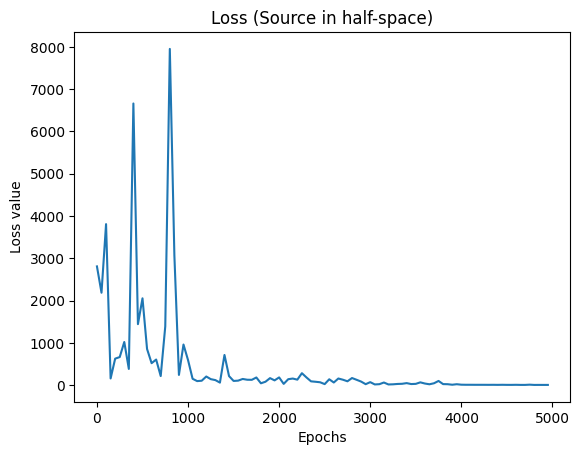

In [11]:
loss = np.load('loss.npy')
loss = loss.tolist()
selected_loss = [loss[i] for i in range(0, len(loss), 50)]
for j in range(49):
    loss_temp = [loss[i] for i in range(j+1, len(loss), 50)]
    for k in range(len(loss_temp)):
        selected_loss[k] += loss_temp[k]

plt.plot(50*np.arange(0, len(selected_loss)), selected_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title('Loss (Source in half-space)')
plt.savefig('loss')